[View in Colaboratory](https://colab.research.google.com/github/maro525/ml/blob/master/maskrcnn.ipynb)

In [0]:
!pwd
!ls

https://qiita.com/nanako_ut/items/cb28d403fcaf013b2396

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# create auth token
from google.colab import auth
auth.authenticate_user()

In [0]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [2]:
!pwd
!ls /content/drive/Notebooks
import os
os.chdir('/content/drive/Notebooks/maskrcnn')

/content
fast-style-transfer  maskrcnn		    pix2pix  Soundscape
gan		     neural-style-transfer  segment  world_image


In [3]:
!pwd
!ls

/content/drive/Notebooks/maskrcnn
Mask_RCNN  maskrcnn.ipynb


In [0]:
#!git clone https://github.com/matterport/Mask_RCNN.git

In [4]:
%cd Mask_RCNN

/content/drive/Notebooks/maskrcnn/Mask_RCNN


In [0]:
!pwd
!ls

In [0]:
!pip install -r requirements.txt

In [0]:
!pwd
!ls

In [0]:
#%run -i setup.py install

In [0]:
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [0]:
#!git clone https://github.com/waleedka/coco.git

In [0]:
!ls

In [0]:
!pip install cython

In [0]:
#%cd coco/PythonAPI

In [0]:
#%run -i setup.py build_ext --inplace

In [0]:
#%run -i setup.py build_ext install

In [0]:
!pwd
!ls

In [0]:
%cd ../../

In [0]:
!pwd
!ls

In [0]:
!pip install keras

In [6]:
!pwd
!ls

/content/drive/Notebooks/maskrcnn/Mask_RCNN
assets	images	     mask_rcnn_coco.h5	 requirements.txt  setup.py
build	LICENSE      mask_rcnn.egg-info  result
coco	logs	     mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


In [0]:
import sys
sys.path.append('coco/PythonAPI')

In [8]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
# ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
# sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
sys.path.append("samples/coco/")
import coco

%matplotlib inline 

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = "logs"

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
COCO_MODEL_PATH = "mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
# IMAGE_DIR = os.path.join(ROOT_DIR, "images")
IMAGE_DIR= "images"

Using TensorFlow backend.


In [9]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (448, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


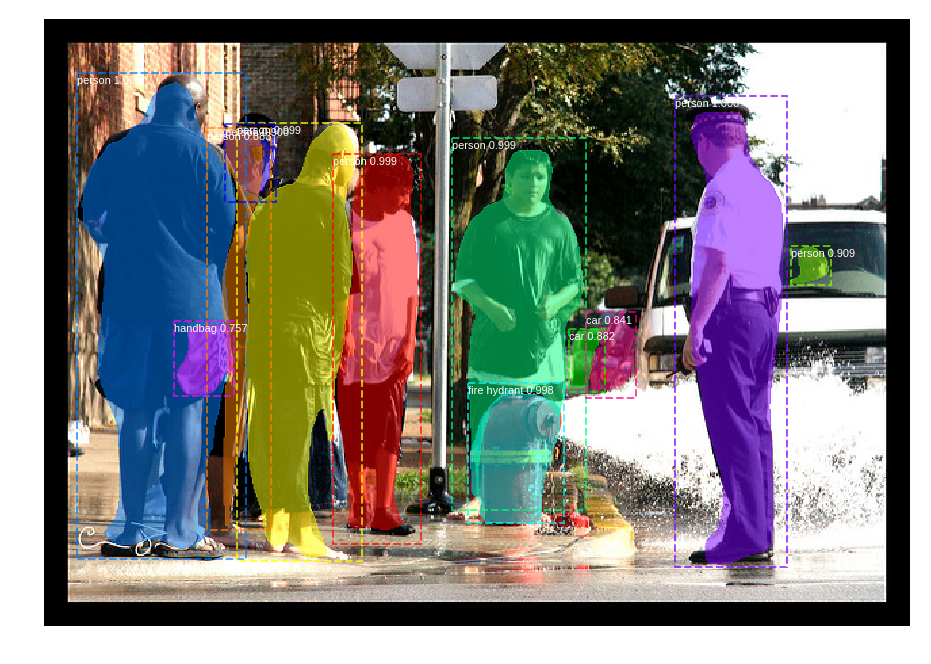

result/1045023827_4ec3e8ba5c_z.jpg saved.
Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


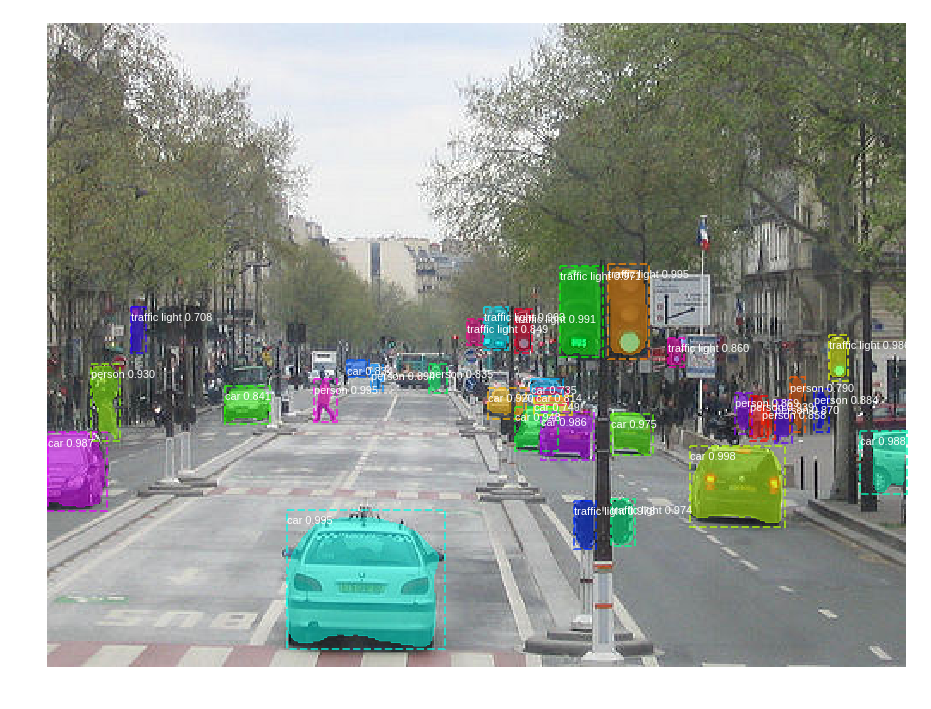

result/12283150_12d37e6389_z.jpg saved.
Processing 1 images
image                    shape: (428, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


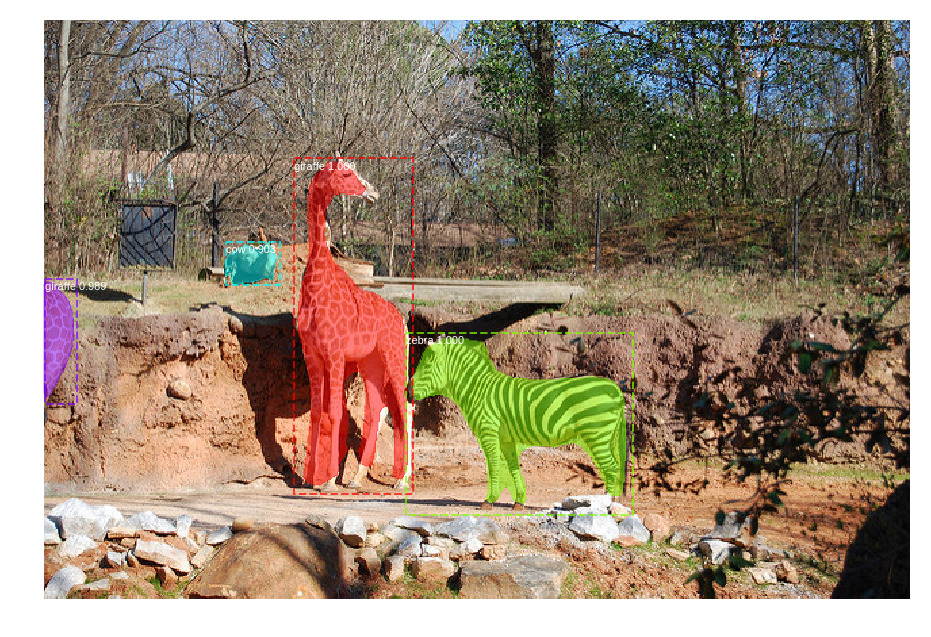

result/2383514521_1fc8d7b0de_z.jpg saved.
Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


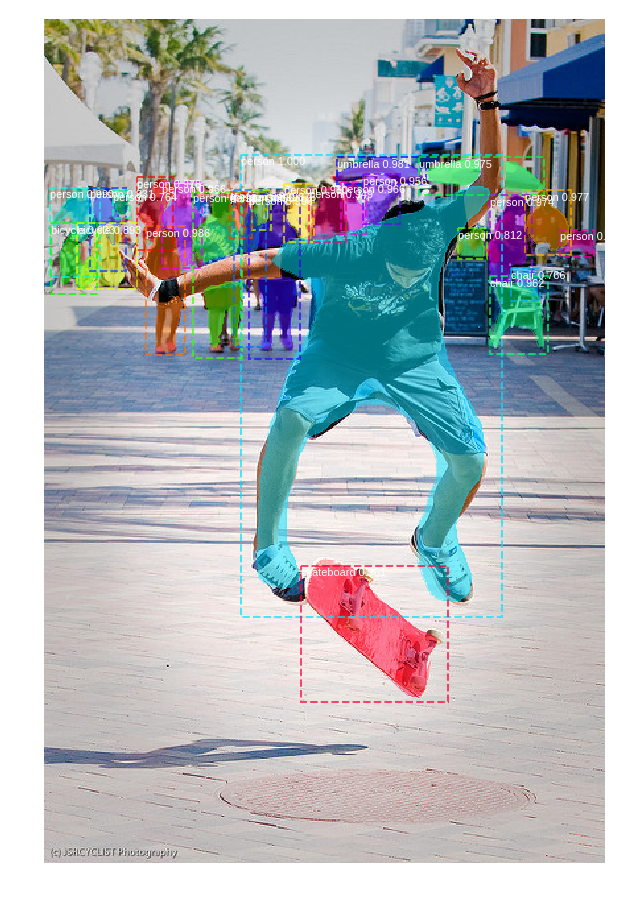

result/2502287818_41e4b0c4fb_z.jpg saved.
Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


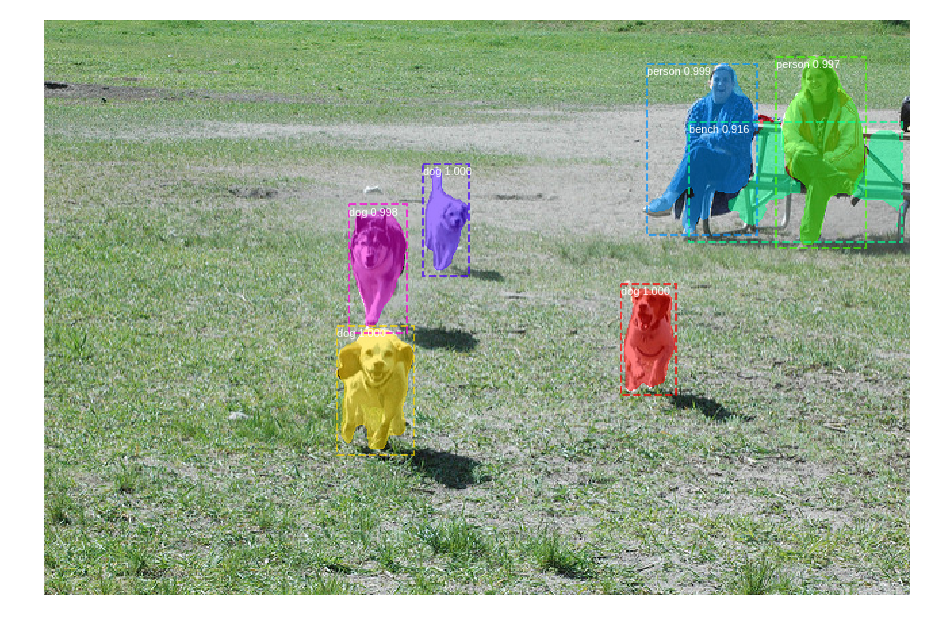

result/2516944023_d00345997d_z.jpg saved.
Processing 1 images
image                    shape: (415, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


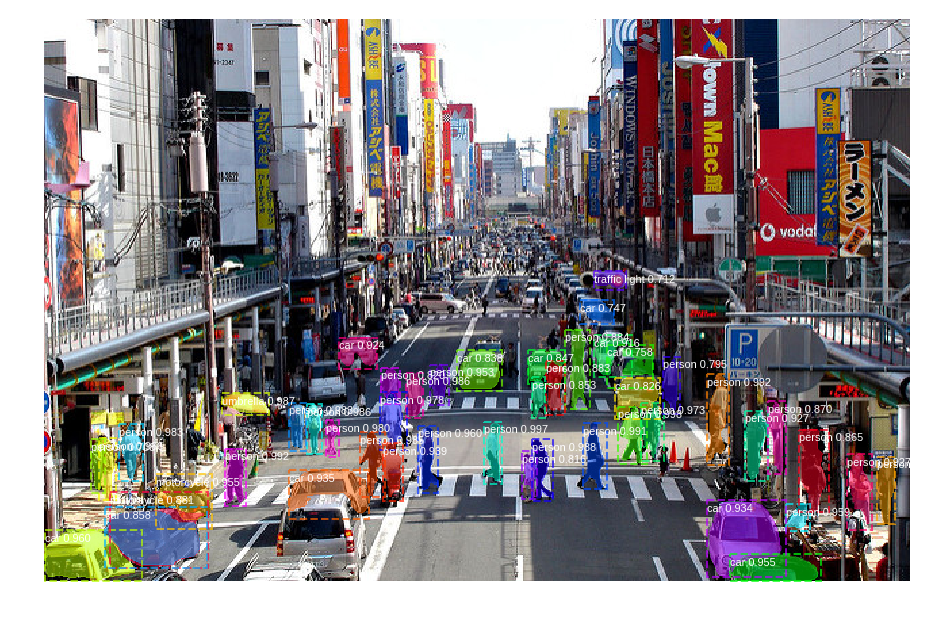

result/25691390_f9944f61b5_z.jpg saved.
Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


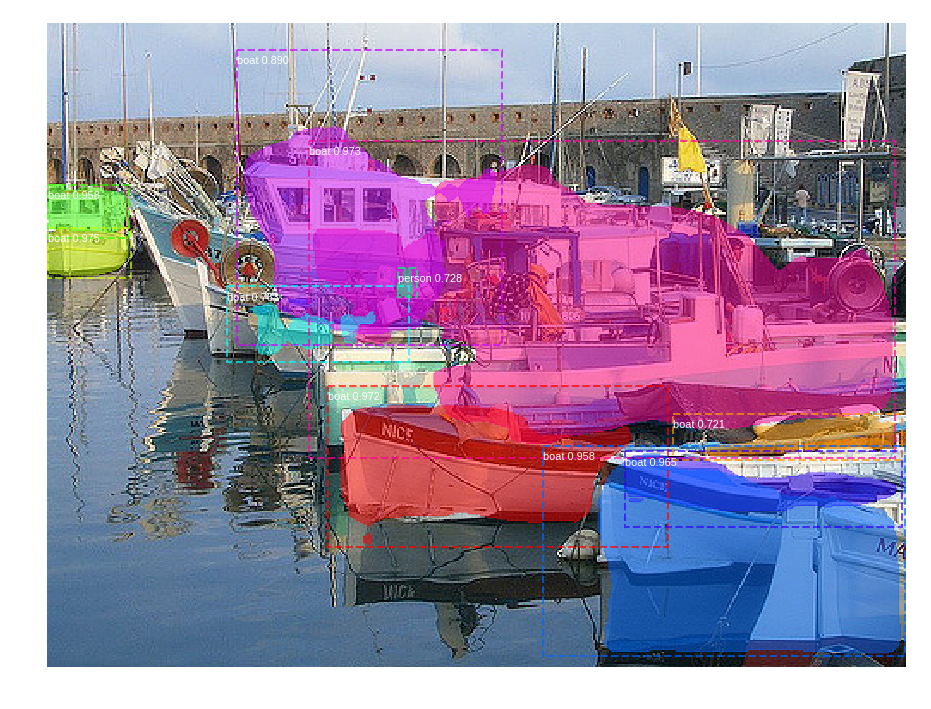

result/262985539_1709e54576_z.jpg saved.
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


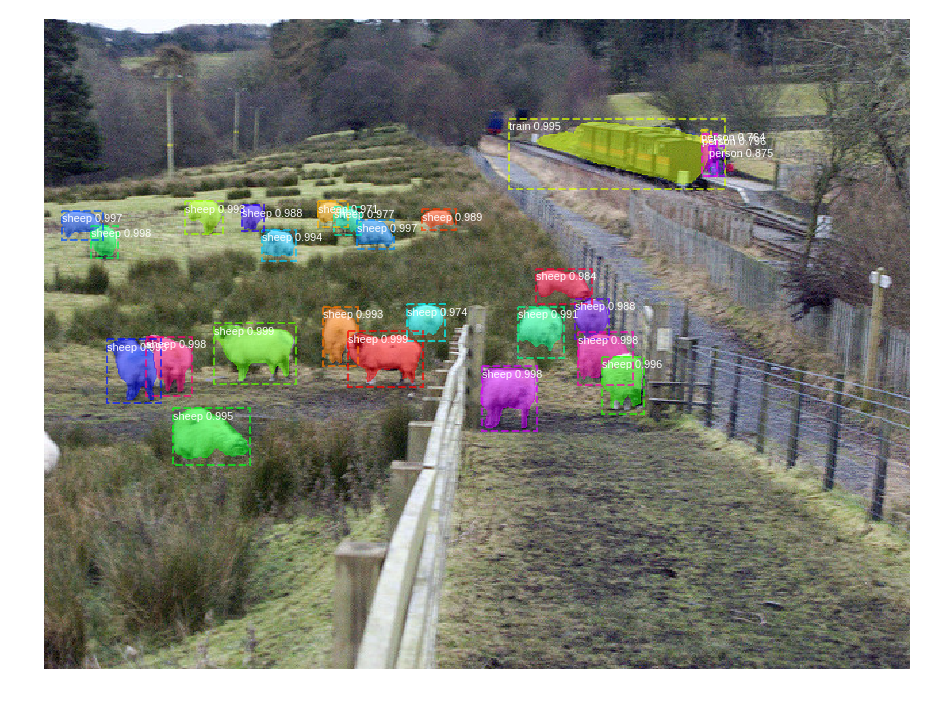

result/3132016470_c27baa00e8_z.jpg saved.
Processing 1 images
image                    shape: (476, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  119.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1.3M of output have been discarded. 

result/3627527276_6fe8cd9bfe_z.jpg saved.
Processing 1 images
image                    shape: (640, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1M of output have been discarded. 

result/3651581213_f81963d1dd_z.jpg saved.
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1M of output have been discarded. 

result/3800883468_12af3c0b50_z.jpg saved.
Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 798.9K of output have been discarded. 

result/3862500489_6fd195d183_z.jpg saved.
Processing 1 images
image                    shape: (334, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 690.5K of output have been discarded. 

result/3878153025_8fde829928_z.jpg saved.
Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 815K of output have been discarded. 

result/4410436637_7b0ca36ee7_z.jpg saved.
Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1M of output have been discarded. 

result/4782628554_668bc31826_z.jpg saved.
Processing 1 images
image                    shape: (511, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 935.9K of output have been discarded. 

result/5951960966_d4e1cda5d0_z.jpg saved.
Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 719.3K of output have been discarded. 

result/6584515005_fce9cec486_z.jpg saved.
Processing 1 images
image                    shape: (438, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1.1M of output have been discarded. 

result/6821351586_59aa0dc110_z.jpg saved.
Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 751.3K of output have been discarded. 

result/7581246086_cf7bbb7255_z.jpg saved.
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1.1M of output have been discarded. 

result/7933423348_c30bd9bd4e_z.jpg saved.
Processing 1 images
image                    shape: (424, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 999.5K of output have been discarded. 

result/8053677163_d4c8f416be_z.jpg saved.
Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 978.5K of output have been discarded. 

result/8239308689_efa6c11b08_z.jpg saved.
Processing 1 images
image                    shape: (437, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 919.6K of output have been discarded. 

result/8433365521_9252889f9a_z.jpg saved.
Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 794.2K of output have been discarded. 

result/8512296263_5fc5458e20_z.jpg saved.
Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1M of output have been discarded. 

result/8699757338_c3941051b6_z.jpg saved.
Processing 1 images
image                    shape: (394, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 895.7K of output have been discarded. 

result/8734543718_37f6b8bd45_z.jpg saved.
Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1009.5K of output have been discarded. 

result/8829708882_48f263491e_z.jpg saved.
Processing 1 images
image                    shape: (626, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1.4M of output have been discarded. 

result/9118579087_f9ffa19e63_z.jpg saved.
Processing 1 images
image                    shape: (491, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1.3M of output have been discarded. 

result/9247489789_132c0d534a_z.jpg saved.
Processing 1 images
image                    shape: (4032, 3024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1.7M of output have been discarded. 

result/test1 (72dbc8b3).jpg saved.


In [12]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
for f in os.listdir('images'):
  image = skimage.io.imread(os.path.join("images", f))

  # Run detection
  results = model.detect([image], verbose=1)

  # Visualize results
  r = results[0]
  masked_image = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'])
  visualize.save_masked(masked_image, os.path.join("result", f))